In [1]:
from IPython.display import Image

# 17. 새로운 데이터 합성을 위한 생성적 적대 신경망
* 새로운 데이터를 합성하기 위한 생성 모델
* 오토인코더(autoencoder), 변이형 오토인코더(Variable AutoEncoder, VAE), GAN과의 관계
* GAN 구성 요소
* 손글씨 숫자를 생성하는 GAN 모델
* 전치 합성곱(transposed convolution)과 배치 정규와(Batch Normalization, BatchNorm, BN)
* GAN 성능향상: 심층 합성곱 GAN과 바서슈타인 거리(Wasserstein distance)를 사용한 GAN

# 17.1 생성적 적대 신경망 소개
* GAN의 주요 목적: 훈련 데이터셋과 동일한 분포를 가진 새로운 데이터를 합성
    * GAN의 원본 형태는 레이블 데이터가 필요하지 않아 머신러닝 비지도 학습 범주로 간주.
    * 원본 GAN을 확장한 것은 비지도 학습과 지도 학습 양쪽으로 모두 볼 수 있다.

### 17.1.1 오토인코더
* 훈련 데이터를 압축하고 해제할 수 있는 **오토인코더**
* 인코더(encoder) 신경망과 디코더(decoder) 신경망 두 개가 연결되어 구성.
* 인코더 신경망
    * 샘플 x에 연관된 d차원의 입력 특성 벡터를 받아 p차원의 벡터 z로 인코딩.
        * z=f(x) 함수를 모델링하는 방법을 배우는 역할
    * 인코딩된 벡터 z를 **잠재 벡터**(latent vector) 또는 잠재 특성 표현이라고도 부른다.
        * 잠재 벡터의 차원은 입력 샘플의 차원보다 작다. 즉, p < d
            * 인코더 데이터가 데이터 압축 기능을 한다.
* 디코더 신경망
    * 저차원 잠재 벡터 z에서 $\hat{x}$를 압축 해제한다.
        * 디코더 = 함수 ( $\hat{x} = g(z)$ )로 생각할 수 있다.
    

인코더 -> $z=f(x)$

디코더 -> $\hat{x}=g(z)$


In [2]:
Image(url='https://git.io/JLAQ2', width=500)

위 그림은 인코더와 디코더 사이에 은닉층이 없는 오토인코더이지만 (다층 신경망처럼) 비선형성을 가진 여러 은닉층을 추가하여 심층 오토인코더를 만들 수 있다. 이렇게 하면 더욱 효과적인 데이터 압축과 재구성 함수를 학습할 수 있다. 여기서 언급한 오토인코더는 완전 연결 층을 사용한다. 이미지를 사용할 때는 완전 연결 층을 합성곱 층으로 바꿀 수 있다.

* 오토인코더와 차원 축소 사이의 관계

인코더와 디코더에 모두 비선형성이 없으면 오토인코더는 거의 PCA와 동일하다. (은닉층이 없고 비선형 활성화 함수가 없는) 단일층 인코더의 가중치를 행렬 U라고 표시하면 인코더는 $z=U^Tx$를 모델링한다. 단일층 선형 디코더는 $\hat{x}=Uz$를 모델링한다. 두 식을 합치면 $\hat{x}= UU^Tx$를 얻는다. PCA가 직교성($UU^T=I_{n*n}$)을 가진다는 제한을 제외하면 PCA가 하는 일과 정확히 동일하다.

* 잠재 공간의 크기에 기반한 다른 종류의 오토인코더

오코인코더의 잠재 공간(latent space) 차원은 일반적으로 입력 차원보다 작다(p < d). 오토인코더를 차원 축소의 용도로 사용하기 위해서이다. 이런 이유로 잠재 벡터를 병목(bottleneck)이라고도 부르며 오토인코더의 이런 성질을 **과소완전**(undercomplete)이라고 부른다. 하지만 **과대완전**(overcomplete)으로 부르는 다른 종류의 오토인코더도 있다. 이 오토인코더의 잠재 벡터 z의 차원은 입력 샘플의 차원보다 크다(p > d).

과대완전 오토인코더를 훈련할 때 인코더와 디코더가 단순히 입력 특성을 (기억하여) 출력층으로 복사할 수 있다. 당연히 이는 유용하지 않다. 훈련 과정을 수정하여 과대완전 오토인코더를 잡음 감소(noise reduction) 용도로 사용할 수 있다.

훈련하는 동안 랜덤한 잡음 $\epsilon$을 입력 샘플에 추가하여 신경망이 잡음이 있는 신호 $x+ϵ$에서 깨끗한 샘플 x를 재구성하는 방법을 배운다. 평가할 때는 원래 잡음이 있는 (즉, 이미 잡음을 포함하고 있어 인공적인 잡음을 추가하지 않은) 새로운 샘플을 제공하여 이 샘플에 있는 잡음을 제거한다. 이런 오토인코더 구조와 훈련 방법을 잡음 제거 오토인코더(denoising autoencoder)라고 부른다.


### 17.1.2 새로운 데이터 합성을 위한 생성 모델

오토인코더는 결정적인 모델. 즉, 오토인코더가 훈련되고 나면 입력 x에 대해 저차원 공간의 압축된 버전에서 이 입력을 재구성할 수 있다. 따라서 압축된 표현을 변환하는 식으로 입력을 재구성하는 것을 넘어서 새로운 데이터를 생성할 수 있다.

반면 생성 모델은 (잠재 표현에 해당하는) 랜덤한 백터 z에서 새로운 샘플 $\tilde{x}$를 생성할 수 있다. 랜덤 벡터 z는 완벽하게 특징을 알고 있는 간단한 분포에서 만들어지기 때문에 쉽게 샘플링할 수 있다.

In [3]:
Image(url='https://git.io/JLAQH', width=700)

생성 모델을 보면 오토인코더의 디코더와 비슷하다. 둘 다 잠재 벡터 z를 입력으로 받고 x와 동일한 공간에 있는 출력을 만든다. (오토인코더에서 $\hat{x}$는 입력 x의 재구성이고 생성 모델에서 $\hat{x}$는 합성된 샘플이다.

이 두 모델의 큰 차이점은 오토인코더에 있는 z의 분포는 알지 못하지만 생성 모델에서는 z의 분포를 완벽하게 알고 있다는 것이다. 오토인코더를 생성 모델로 일반화 할 수도 있다. VAE가 그 중 한 가지 방법이다.

VAE에서는 입력 샘플 x를 받으면 인코더 신경망이 잠재 벡터 분포의 두 요소 평균 $\mu$와 분산 $\sigma^2$을 계산한다. VAE를 훈련하는 동안 이 평균과 분산을 (평균이 0이고 단위 분산인) 표준 정규 분포에 맞추도록 신경망을 조정한다. VAE 모델을 훈련한 후 인코더는 떼어 내고 디코더 신경망을 사용하여 가우시안 분포에서 랜덤하게 샘플링한 z 벡터를 주입해서 새로운 샘플 $\hat{x}$를 생성한다.

VAE 외에도 자기회귀 모델(autoregressive model)과 노멀라이징 플로 모델(normalizing flow model)과 같은 다른 종류의 생성 모델이 있다.

* 생성 모델이란

생성 모델은 전통적으로 데이터 입력 분포 p(x) 또는 입력 데이터와 연관된 타깃의 결합 분포(joint distribution) p(x, y)를 모델링하는 알고리즘으로 정의한다. 정의에 따라 이런 모델은 다른 특성 $x_j$를 조건으로 어떤 특성 $x_i$를 샘플링할 수 있다. 이를 조건부 추론이라고 한다. 하지만 딥러닝에서 일반적으로 생성 모델이라 함은 진짜처럼 보이는 데이터를 생성하는 모델을 말한다. 즉, 입력 분포 p(x)에서 샘플링할 수 있지만 조건부 추론을 수행할 필요는 없다.

### 17.1.3 GAN으로 새로운 샘플 생성

분포에서 샘플링한 랜덤 벡터 z를 입력받아 출력 이미지 x를 생성하는 신경망이 있다고 할때, 이 신경망을 **신경망**(G)이라고 부르며, $\hat{x}=G(z)$는 생성된 출력이다.

신경망을 랜덤한 가중치로 초기화한다. 따라서 가중치가 학습되기 전에 출력한 이미지는 백색 소음과 비슷할 것이다. 이미지의 품질을 평가하는 함수를 평가 함수라 한다.

이런 함수에서 피드백을 받아 생성된 이미지의 품질을 높이기 위해 가중치를 수정핟로고 생성자 신경망에 알려준다. 그리고 이런 식으로 평가 함수의 피드백을 기반으로 생성자를 훈련시킬 수 있다. 생성자는 출력을 개선하여 진짜 이미지처럼 보이도록 학습될 것이다.

GAN 모델은 **판별자**(discriminator)(D)라고 불리는 또 다른 신경망으로 구성되어 있다. 판별자는 진짜 이미지 x에서 합성 이미지 $\hat{x}$를 감지하는 법을 학습하는 분류기이다.

In [4]:
# GAN 모델
Image(url='https://git.io/JLAQ7', width=700)

GAN에서 생성자와 판별자 두 신경망이 함께 훈련된다. 먼저 모델 가중치를 초기화한 후 생성자가 진짜처럼 보이지 않은 이미지를 만든다. 비슷하게 판별자는 진짜 이미지와 생성자가 합성한 가짜 이미지를 구분하는 능력이 형편없다. 하지만 시간이 지남에 따라 (훈련을 통해) 두 신경망이 서로 상호 작용을 하면서 향상된다. 두 신경망은 적대적인 게임을 수행한다. 생성자는 판별자를 속이기 위해 출력을 향상시키도록 학습되고, 동시에 판별자는 합성 이미지를 더 잘 감지하도록 훈련된다.

### 17.1.4 GAN의 생성자와 판별자 손실 함수 이해

* GAN 목적 함수

$$V(\theta^{(D)}, \theta^{(G)}) = E_{x~p_{data}(x)}[logD(x)] + E_{z~p_z(z)} [log(1-D(G(z)))]$$

$V(\theta^{(D)}, \theta^{(G)})$를 가치 함수라고 부른다. 이를 보상으로 생각할 수 있다. 판별자(D)에 대해 이 값을 최대화하고 생성자(G)에 대해서는 이 값을 최소화해야 한다. 

D(x)는 입력 샘플 x가 진짜인지 가짜(생성된 것)인지 나타내는 확률이다.

$E_{x~p_{data}(x)}[logD(x)]$는 데이터 분포(진짜 샘플의 분포)에서 온 샘플에 대한 대괄호 안에 있는 식의 기댓값을 나타낸다

$E_{z~p_z(z)} [log(1-D(G(z)))]$는 입력 벡터 z에 대한 대괄호 안에 있는 식의 기대값을 나타낸다

이런 가치 함수를 사용한 GAN 모델의 훈련은 두 개의 최적화 단계가 필요하다

1. 판별자에 대한 보상을 최대화
2. 생성자에 대한 보상을 최소화

실용적인 GAN 훈련 방법은 두 최적화 단계를 교대로 수행하는 것이다.

1. 한 신경망의 가중치를 고정(동결)하고 다른 신경망의 가중치를 쵲거화
2. 두 번째 신경망을 고정하고 첫 번째 신경망 최적화

훈련마다 위 과정을 반복한다. 생성자 신경망을 고정하고 판별자를 최적화한다고 할때, 가치 함수 $V(\theta^{(D)}, \theta^{(G)})$의 두 항이 모두 판별자를 최적화하는 데 기여한다. 첫 번째 항은 진짜 샘플에 연관된 손실이고, 두 번째 항은 가짜 샘플에 연관된 손실이다. 따라서 G를 고정하면 $V(\theta^{(D)}, \theta^{(G)})$를 최대화 하는 것이 목적 함수가 된다. 즉, 판별자가 진짜와 가짜를 더 잘 구분하도록 만드는 것이다.

진짜와 가짜 샘플에 대한 손실을 사용하여 판별자를 최적화한 후 판별자를 고정하고 생성자를 최적화한다. 이 경우 $V(\theta^{(D)}, \theta^{(G)})$에 있는 두 번째 항만 생성자의 그레이디언트에 기여한다. 결국 D를 고정할 때 $V(\theta^{(D)}, \theta^{(G)})$를 최소화하는 목적 함수는 $min_GE_{z~p_z(z)[log(1-D(G(z)))]}$로 쓸 수 있다. 굿펠로우의 원본 GAN 논문에 따르면 log(1-D(G(z))) 함수는 초기 훈련 단계에서 그레이디언트 손실 문제가 발생한다. 이 때문에 훈련 초기에 출력을 G(z)는 진짜 샘플처럼 전혀 보이진 않는다. 따라서 D(G(z))는 거의 0에 가까워질 것이다. 이런 현상을 포화되었다고 한다. 이 문제를 해결하기 위해 최소화하려는 목적 함수 $min_GE_{z~p_z(z)[log(1-D(G(z)))]}$를 $max_GE_{z~p_z(z)}[log(1-D(G(z)))]$로 바꿔 쓸 수 있다.

이렇게 식을 바꾸는 것은 생성자 훈련에서 진짜와 가짜 샘플의 이미지를 뒤바꾸고 일반적인 함수 최솟값을 찾는 작업을 의미한다. 즉, 생성자가 합성한 샘플이 가짜라서 레이블이 0이더라도 이 샘플의 레이블을 1로 바꾼다. 그 다음 $max_GE_{z~p_z(z)}[log(1-D(G(z)))]$를 최대화하는 대신 새로운 레이블로 이진 크로스 엔트로피 손실을 최소화할 수 있다.

판별자가 이진 분류기이면 이진 크로스 엔트로피 손실 함수를 사용할 수 있다. 따라서 판별자 손실을 위한 정답 레이블은 다음과 같이 결정할 수 잇다.

* 판별자를 위한 정답 레이블 
    * 1: 진짜 이미지일 때, 즉 x
    * 0: 생성자의 출력일 때, 즉 G(z)

생성자는 진짜 같은 이미지를 합성해야 하기 때문에 판별자가 생성자의 출력을 진짜로 분류하지 않으면 생성자에게 벌칙을 부여할 수 있다. 생성자의 손실 함수를 계산할 때 생성자의 출려에 대한 레이블을 1로 가정한다.

In [5]:
# GAN 훈련 단계
Image(url='https://git.io/JLAQF', width=800)

# 17.2 밑바닥부터 GAN 모델 구현

* MNIST 숫자와 비슷한 새로운 이미지를 생성하는 GAN 모델을 구현하고 훈련하는 방법

In [6]:
import tensorflow as tf
print(tf.__version__)

print("GPU 여부:", len(tf.config.list_physical_devices('GPU')) > 0)

if tf.config.list_physical_devices('GPU'):
    device_name = tf.test.gpu_device_name()
else:
    device_name = 'cpu:0'
    
print(device_name)

2.8.0
GPU 여부: True
/device:GPU:0


In [7]:
# gpu 메모리 사용량 확인
tf.config.experimental.get_memory_usage('GPU:0')

Instructions for updating:
Use tf.config.experimental.get_memory_info(device)['current'] instead.


0

In [8]:
# NVIDIA GPU 관리 유틸리티인 nvidia-smi 명령을 실행하면 사용하고 있는 GPU 이름과 다양한 부가 정보를 얻을 수 있다.
!nvidia-smi

Sun Feb 20 06:29:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    64W / 149W |    145MiB / 11441MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [9]:
!lsb_release -a

No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 18.04.5 LTS
Release:	18.04
Codename:	bionic


### 17.2.2 생성자와 판별자 신경망 구현
* GAN 모델
    * 원본 GAN - 바닐라(vanilla) GAN
    * 각 은닉층에는 LeakyReLU 활성화 함수 사용
        * 렐루를 사용하면 희소한 그레이디언트가 발생하기 때문에 입력 값 전 범위에 걸쳐 그레이디언트가 필요할 때는 적합하지 않다.
    * 판별자 신경망에서 각 은닉층 다음에는 드롭아웃 층이 뒤따름
    * 생성자의 출력층은 하이퍼볼릭 탄젠트(tanh) 활성화 함수를 사용
        * 생성자 신경망에 tanh 활성화 함수를 사용하면 학습에 도움된다.
    * 판별자 출력층은 로짓을 계산하기 위해 활성화 함수를 가지지 않는다.
        * 선형 활성화 함수를 사용
        * 또는, 확률을 출력으로 얻기 위해 시그모이드 활성화 함수를 사용할 수 있다.

In [10]:
# 생성자와 판별자의 활성화 함수
Image(url='https://git.io/JLAQp', width=600)

* LeakyReLU 활성화 함수

렐루 활성화 함수는 $\phi(z) = max(0, z)$로 정의되기 때문에 (활성화 함수에 들어오는) 음수는 버려진다. 즉, 음수 입력은 0으로 설정.

이로 인해 렐루 활성화 함수는 역전파될 때 희소한 그레이디언트를 만들 수 있다. 희소한 그레이디언트가 항상 나쁜 것은 아니고 분류 모델에는 도움이 될 수 있다.

하지만 GAN 같은 일부 애플리케이션에서는 입력값의 전 범위에 대한 그레이디언트를 사용하는 것이 좋다. 음수 값을 조금 출력하도록 렐루 함수를 수정하면 이렇게 만들 수 있다. 이런 렐루 함수의 수정된 버전을 LeakyReLU라고 부른다.

즉, LeakyReLU 활성화 함수는 음수 입력에서도 0이 아닌 그레이디언트를 만든다. 따라서 신경망이 대체적으로 더 많은 것을 표현할 수 있다.

In [11]:
# LeakyReLU 활성화 함수
# a는 (활성화 함수에 들어오는) 음수 입력을 위한 기울기를 결정
Image(url='https://git.io/JLAQh', width=600)

In [12]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

In [13]:
# 두 신경망을 위해 두 개의 헬퍼 함수를 정의

## 생성자 함수를 정의합니다:
def make_generator_network(
        num_hidden_layers=1,
        num_hidden_units=100,
        num_output_units=784):
    model = tf.keras.Sequential()
    for i in range(num_hidden_layers):
        model.add(
            tf.keras.layers.Dense(
                units=num_hidden_units, 
                use_bias=False)
            )
        model.add(tf.keras.layers.LeakyReLU())
        
    model.add(tf.keras.layers.Dense(
        units=num_output_units, activation='tanh'))
    return model

## 판별자 함수를 정의합니다:
def make_discriminator_network(
        num_hidden_layers=1,
        num_hidden_units=100,
        num_output_units=1):
    model = tf.keras.Sequential()
    for i in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(units=num_hidden_units))
        model.add(tf.keras.layers.LeakyReLU())
        model.add(tf.keras.layers.Dropout(rate=0.5))
        
    model.add(
        tf.keras.layers.Dense(
            units=num_output_units, 
            activation=None)
        )
    return model

* 모델 훈련을 위한 설정
    * MNIST 이미지는 28 * 28 픽셀 크기(MNIST는 흑백 이미지이기 때문에 채널은 1)
    * 입력 벡터 z의 크기를 20으로 지정하고 모델 가중치를 균등 분포로 랜덤하게 초기화
    * 아주 간단한 GAN 모델을 구현하기 때문에 완전 연결 층을 사용하고 각 신경층마다 100개의 유닛을 가진 하나의 은닉층만 사용


In [14]:
image_size = (28, 28)
z_size = 20
mode_z = 'uniform'  # 'uniform' vs. 'normal'
gen_hidden_layers = 1
gen_hidden_size = 100
disc_hidden_layers = 1
disc_hidden_size = 100

tf.random.set_seed(1)

gen_model = make_generator_network(
    num_hidden_layers=gen_hidden_layers, 
    num_hidden_units=gen_hidden_size,
    num_output_units=np.prod(image_size))

gen_model.build(input_shape=(None, z_size))
gen_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               2000      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 784)               79184     
                                                                 
Total params: 81,184
Trainable params: 81,184
Non-trainable params: 0
_________________________________________________________________


In [15]:
disc_model = make_discriminator_network(
    num_hidden_layers=disc_hidden_layers,
    num_hidden_units=disc_hidden_size)

disc_model.build(input_shape=(None, np.prod(image_size)))
disc_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 100)               78500     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 100)               0         
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 78,601
Trainable params: 78,601
Non-trainable params: 0
_________________________________________________________________


### 17.2.3 훈련 데이터셋 정의

MNIST 데이터셋을 로드하고 필요한 전처리 단계를 적용.

생성자 출력층이 tanh 활성화 함수를 사용하기 때문에 합성된 이미지가 갖는 픽셀 값의 범위는 (-1, 1)이다. 하지만 입력되는 MNIST 이미지 픽셀의 범위는 [0, 255]이다. 따라서 전처리 단계에서 tf.image.convert_image_dtype 함수를 사용해서 입력 이미지 텐서의 dtype을 tf.uint8에서 tf.float32로 바꾼다. 또한 픽셀 강도의 범위를 [0, 1]로 바꾼다. 여기에 2를 곱하고 1을 빼서 픽셀 강도를 [-1, 1] 범위로 조정한다. 또한, 랜덤한 분포(균등 또는 정규 분포)를 기반으로 랜덤 벡터 z를 만든다. 그 다음 전처리된 이미지와 랜덤 벡터를 튜플로 반환한다.

In [16]:
mnist_bldr = tfds.builder('mnist')
mnist_bldr.download_and_prepare()
mnist = mnist_bldr.as_dataset(shuffle_files=False)

def preprocess(ex, mode='uniform'):
    image = ex['image']
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.reshape(image, [-1])
    image = image*2 - 1.0
    if mode == 'uniform':
        input_z = tf.random.uniform(
            shape=(z_size,), minval=-1.0, maxval=1.0)
    elif mode == 'normal':
        input_z = tf.random.normal(shape=(z_size,))
    return input_z, image

mnist_trainset = mnist['train']

print('전처리 전:  ')
example = next(iter(mnist_trainset))['image']
print('dtype: ', example.dtype, ' 최소: {} 최대: {}'.format(np.min(example), np.max(example)))

mnist_trainset = mnist_trainset.map(preprocess)

print('전처리 후:  ')
example = next(iter(mnist_trainset))[0]
print('dtype: ', example.dtype, ' 최소: {} 최대: {}'.format(np.min(example), np.max(example)))

전처리 전:  
dtype:  <dtype: 'uint8'>  최소: 0 최대: 255
전처리 후:  
dtype:  <dtype: 'float32'>  최소: -0.8737728595733643 최대: 0.9460210800170898


모델을 훈련할 때 입력 벡터 z와 훈련 데이터에서 추출한 이미지를 함께 반환했다. 하지만 이것이 벡터 z가 데이터셋에 있는 입력 이미지와 관련이 있다는 의미는 아니다. 훈련 반복마다 랜덤하게 생성된 벡터 z는 생성자가 새로운 이미지를 위해 받는 입력이다. 그리고 (진짜 이미지와 합성된 이미지를 포함한) 이미지는 판별자 입력이다.

In [17]:
mnist_trainset = mnist_trainset.batch(32, drop_remainder=True) # 한 개의 배치를 추출
input_z, input_real = next(iter(mnist_trainset))
# 입력 벡터와 이미지 배열의 크기 출력
print('input-z -- 크기:', input_z.shape)
print('input-real -- 크기:', input_real.shape)

# 입력 벡터 z의 배치를 생성자에 주입하여 출력 g_output을 얻는다 - 가짜 샘플의 배치
g_output = gen_model(input_z)
print('생성자 출력 -- 크기:', g_output.shape)

# 데이터셋 객체에서 가져온 전처리된 이미지를 판별자 
d_logits_real = disc_model(input_real)
# 가짜 샘플 배치를 판별자 모델에 주입하여 가짜 샘플의 배치 로짓을 얻는다
d_logits_fake = disc_model(g_output)
print('판별자 (진짜) -- 크기:', d_logits_real.shape)
print('판별자 (가짜) -- 크기:', d_logits_fake.shape)

input-z -- 크기: (32, 20)
input-real -- 크기: (32, 784)
생성자 출력 -- 크기: (32, 784)
판별자 (진짜) -- 크기: (32, 1)
판별자 (가짜) -- 크기: (32, 1)


### 17.2.4 GAN 모델 훈련

In [18]:
# 손실 함수를 위해 BinaryCrossentropy 클래스 객체를 만들어 처리한 배치에 대해 생성자와 판별자의 손실을 계산
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# 생성자와 팔변자 손실 계산을 위한 출력에 대한 정답 레이블
# 생성자 손실
g_labels_real = tf.ones_like(d_logits_fake) # 1로 채워진 생성된 이미지의 로짓 값을 담은 벡터 d_logits_fake와 같은 크기의 벡터
g_loss = loss_fn(y_true=g_labels_real, y_pred=d_logits_fake)
print('생성자 손실: {:.4f}'.format(g_loss))

# 판별자 손실
# 가짜 샘플을 위한 정답 레이블은 0으로 채워진 벡터
d_labels_real = tf.ones_like(d_logits_real)
d_labels_fake = tf.zeros_like(d_logits_fake)

d_loss_real = loss_fn(y_true=d_labels_real, y_pred=d_logits_real)
d_loss_fake = loss_fn(y_true=d_labels_fake, y_pred=d_logits_fake)
print('판별자 손실: 진짜 {:.4f} 가짜 {:.4f}'
      .format(d_loss_real.numpy(), d_loss_fake.numpy()))

생성자 손실: 0.7355
판별자 손실: 진짜 1.5073 가짜 0.6583


#### 최종 훈련

In [19]:
import time

num_epochs = 100
batch_size = 64
image_size = (28, 28)
z_size = 20
mode_z = 'uniform'
gen_hidden_layers = 1
gen_hidden_size = 100
disc_hidden_layers = 1
disc_hidden_size = 100

tf.random.set_seed(1)
np.random.seed(1)

if mode_z == 'uniform':
    fixed_z = tf.random.uniform(
        shape=(batch_size, z_size),
        minval=-1, maxval=1)
elif mode_z == 'normal':
    fixed_z = tf.random.normal(
        shape=(batch_size, z_size))


def create_samples(g_model, input_z):
    g_output = g_model(input_z, training=False)
    images = tf.reshape(g_output, (batch_size, *image_size))    
    return (images+1)/2.0

## 데이터셋 준비
mnist_trainset = mnist['train']
mnist_trainset = mnist_trainset.map(
    lambda ex: preprocess(ex, mode=mode_z))

mnist_trainset = mnist_trainset.shuffle(10000)
mnist_trainset = mnist_trainset.batch(
    batch_size, drop_remainder=True)

## 모델 준비
with tf.device(device_name):
    gen_model = make_generator_network(
        num_hidden_layers=gen_hidden_layers, 
        num_hidden_units=gen_hidden_size,
        num_output_units=np.prod(image_size))
    gen_model.build(input_shape=(None, z_size))

    disc_model = make_discriminator_network(
        num_hidden_layers=disc_hidden_layers,
        num_hidden_units=disc_hidden_size)
    disc_model.build(input_shape=(None, np.prod(image_size)))

## 손실 함수와 옵티마이저
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
g_optimizer = tf.keras.optimizers.Adam()
d_optimizer = tf.keras.optimizers.Adam()

all_losses = []
all_d_vals = []
epoch_samples = []

start_time = time.time()
# GAN 모델을 만들고 훈련 반복을 위해 for 문 안에서 여러 손실 항을 단계별로 계산 수행
for epoch in range(1, num_epochs+1):
    epoch_losses, epoch_d_vals = [], []
    for i, (input_z,input_real) in enumerate(mnist_trainset):

        ## 생성자 손실을 계산한다
        # tf.GradientTape()로 모델의 가중치에 대한 손실의 그레이디언트를 계산하고
        # 두 개의 Adam 옵티마이저를 사용하여 생성자와 판별자의 파라미터를 최적화한다.
        # 생성자와 판별자를 교대로 훈련하기 위해 각 신경망의 옵티마이저에 따로따로 
        # 해당하는 신경망의 파라미터와 그레이디언트를 전달한다.
        with tf.GradientTape() as g_tape:
            g_output = gen_model(input_z)
            d_logits_fake = disc_model(g_output, training=True)
            labels_real = tf.ones_like(d_logits_fake)
            g_loss = loss_fn(y_true=labels_real, y_pred=d_logits_fake)
        
        # g_loss의 그레이디언트 계산
        g_grads = g_tape.gradient(g_loss, gen_model.trainable_variables)

        # 최적화: 그레이디언트 적용
        g_optimizer.apply_gradients(
            grads_and_vars=zip(g_grads, gen_model.trainable_variables))
        
        # 판별자 손실을 계산
        with tf.GradientTape() as d_tape:
            d_logits_real = disc_model(input_real, training=True)
            d_labels_real = tf.ones_like(d_logits_real)
            d_loss_real = loss_fn(y_true=d_labels_real, y_pred=d_logits_real)

            d_logits_fake = disc_model(g_output, training=True)
            d_labels_fake = tf.zeros_like(d_logits_fake)
            d_loss_fake = loss_fn(y_true=d_labels_fake, y_pred=d_logits_fake)

            d_loss = d_loss_real + d_loss_fake
        
        # d_loss의 그레이디언트 계산
        d_grads = d_tape.gradient(d_loss, disc_model.trainable_variables)

        # 최적화: 그레이디언트 적용
        d_optimizer.apply_gradients(
            grads_and_vars=zip(d_grads, disc_model.trainable_variables))
        
        epoch_losses.append(
            (g_loss.numpy(), d_loss.numpy(), 
             d_loss_real.numpy(), d_loss_fake.numpy()))
        
        d_probs_real = tf.reduce_mean(tf.sigmoid(d_logits_real))
        d_probs_fake = tf.reduce_mean(tf.sigmoid(d_logits_fake))
        epoch_d_vals.append((d_probs_real.numpy(), d_probs_fake.numpy()))  
    all_losses.append(epoch_losses)
    all_d_vals.append(epoch_d_vals)
    print(
        '에포크 {:03d} | 시간 {:.2f} min | 평균 손실 >>'
        ' 생성자/판별자 {:.4f}/{:.4f} [판별자-진짜: {:.4f} 판별자-가짜: {:.4f}]'
        .format(
            epoch, (time.time() - start_time)/60, 
            *list(np.mean(all_losses[-1], axis=0))))
    epoch_samples.append(
        create_samples(gen_model, fixed_z).numpy())

에포크 001 | 시간 0.97 min | 평균 손실 >> 생성자/판별자 2.8685/0.2893 [판별자-진짜: 0.0333 판별자-가짜: 0.2560]
에포크 002 | 시간 1.65 min | 평균 손실 >> 생성자/판별자 4.9915/0.3699 [판별자-진짜: 0.1245 판별자-가짜: 0.2453]
에포크 003 | 시간 3.02 min | 평균 손실 >> 생성자/판별자 3.3765/0.6493 [판별자-진짜: 0.2919 판별자-가짜: 0.3574]
에포크 004 | 시간 3.69 min | 평균 손실 >> 생성자/판별자 2.0895/0.8305 [판별자-진짜: 0.4371 판별자-가짜: 0.3933]
에포크 005 | 시간 4.36 min | 평균 손실 >> 생성자/판별자 2.2095/0.8203 [판별자-진짜: 0.4336 판별자-가짜: 0.3867]
에포크 006 | 시간 5.03 min | 평균 손실 >> 생성자/판별자 1.6843/0.9261 [판별자-진짜: 0.5068 판별자-가짜: 0.4193]
에포크 007 | 시간 5.71 min | 평균 손실 >> 생성자/판별자 1.6418/0.9769 [판별자-진짜: 0.5236 판별자-가짜: 0.4534]
에포크 008 | 시간 6.38 min | 평균 손실 >> 생성자/판별자 1.5165/0.9829 [판별자-진짜: 0.5368 판별자-가짜: 0.4461]
에포크 009 | 시간 7.06 min | 평균 손실 >> 생성자/판별자 1.5745/0.9902 [판별자-진짜: 0.5383 판별자-가짜: 0.4519]
에포크 010 | 시간 7.73 min | 평균 손실 >> 생성자/판별자 1.4141/1.0260 [판별자-진짜: 0.5549 판별자-가짜: 0.4711]
에포크 011 | 시간 8.40 min | 평균 손실 >> 생성자/판별자 1.3049/1.0918 [판별자-진짜: 0.5799 판별자-가짜: 0.5118]
에포크 012 | 시간 9.07 min | 평균 손실 >> 생성자/판별자 1.

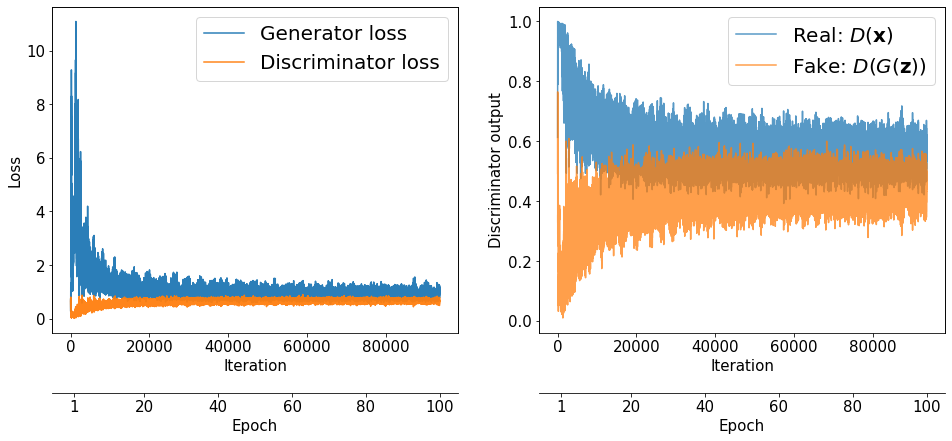

In [20]:
# 판별자와 생성자 손실을 그래프 시각화 - 두 신경망의 훈련 과정을 분석하고 수렴하는지 평가
# 반복마다 판별자에서 계산한 진짜 샘플과 가짜 샘플의 평균 확률 출력
# 이 확률이 0.5 근처라면 판별자가 진짜와 가짜 이미지를 잘 구분할 수 없다는 뜻.
import itertools

fig = plt.figure(figsize=(16, 6))

# 손실 그래프
ax = fig.add_subplot(1, 2, 1)
g_losses = [item[0] for item in itertools.chain(*all_losses)]
d_losses = [item[1]/2.0 for item in itertools.chain(*all_losses)]
plt.plot(g_losses, label='Generator loss', alpha=0.95)
plt.plot(d_losses, label='Discriminator loss', alpha=0.95)
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Loss', size=15)

epochs = np.arange(1, 101)
epoch2iter = lambda e: e*len(all_losses[-1])
epoch_ticks = [1, 20, 40, 60, 80, 100]
newpos = [epoch2iter(e) for e in epoch_ticks]
ax2 = ax.twiny()
ax2.set_xticks(newpos)
ax2.set_xticklabels(epoch_ticks)
ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 60))
ax2.set_xlabel('Epoch', size=15)
ax2.set_xlim(ax.get_xlim())
ax.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)

# 판별자 출력
ax = fig.add_subplot(1, 2, 2)
d_vals_real = [item[0] for item in itertools.chain(*all_d_vals)]
d_vals_fake = [item[1] for item in itertools.chain(*all_d_vals)]
plt.plot(d_vals_real, alpha=0.75, label=r'Real: $D(\mathbf{x})$')
plt.plot(d_vals_fake, alpha=0.75, label=r'Fake: $D(G(\mathbf{z}))$')
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Discriminator output', size=15)

ax2 = ax.twiny()
ax2.set_xticks(newpos)
ax2.set_xticklabels(epoch_ticks)
ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 60))
ax2.set_xlabel('Epoch', size=15)
ax2.set_xlim(ax.get_xlim())
ax.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)

plt.show()

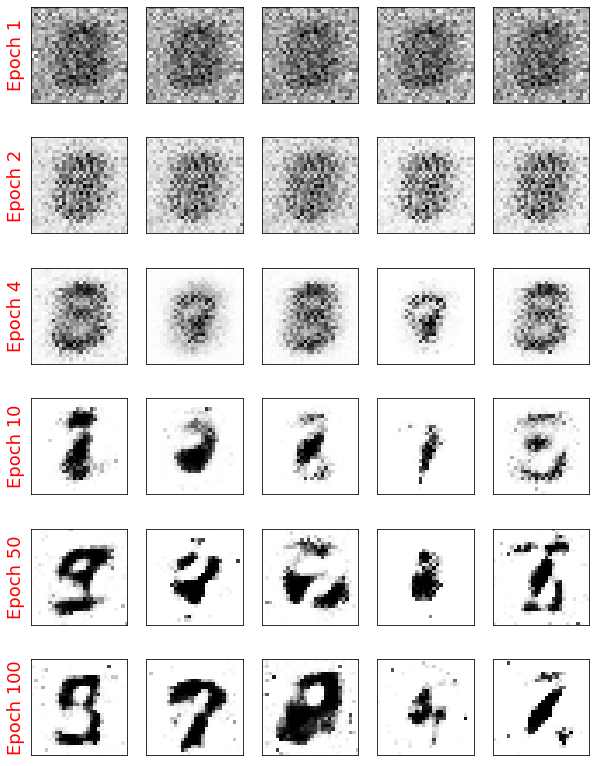

In [21]:
selected_epochs = [1, 2, 4, 10, 50, 100]
fig = plt.figure(figsize=(10, 14))
for i,e in enumerate(selected_epochs):
    for j in range(5):
        ax = fig.add_subplot(6, 5, i*5+j+1)
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.text(
                -0.06, 0.5, 'Epoch {}'.format(e),
                rotation=90, size=18, color='red',
                horizontalalignment='right',
                verticalalignment='center', 
                transform=ax.transAxes)
        
        image = epoch_samples[e-1][j]
        ax.imshow(image, cmap='gray_r')

plt.show()